<a href="https://colab.research.google.com/github/stiwari-ds/DL-Simplified-SWOC-S3/blob/facial-emotion-detection/Facial-Emotion-Detection/Model/01_cnn_with_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import gc
import os
import subprocess
import warnings

gc.enable()
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization)
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, get_file

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    ConfusionMatrixDisplay, accuracy_score, top_k_accuracy_score, f1_score)

In [ ]:
SEED = 2311
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
#Check GPU availability
try:
    subprocess.check_output('nvidia-smi')
    HAVE_GPU = True
except Exception:
    HAVE_GPU = False

print(f'GPU available: {HAVE_GPU}')

GPU available: True


# Data

In [ ]:
DATA_URL = 'https://storage.googleapis.com/dl-simplified/facial_emotion_npy.zip'

In [ ]:
path = tf.keras.utils.get_file('facial_emotion_npy.zip', DATA_URL)
with np.load(path) as data:
    images = data['Facial expression.npy']
    labels = data['Facial expression label.npy']

62421351/62421351 [==============================] - 5s 0us/step


In [ ]:
images.shape, labels.shape

((19950, 48, 48, 3), (19950, 4))

# Basic EDA

In [ ]:
images[0]

array([[[216, 216, 216],
        [149, 149, 149],
        [158, 158, 158],
        ...,
        [177, 177, 177],
        [183, 183, 183],
        [178, 178, 178]],

       [[181, 181, 181],
        [157, 157, 157],
        [172, 172, 172],
        ...,
        [179, 179, 179],
        [188, 188, 188],
        [185, 185, 185]],

       [[157, 157, 157],
        [167, 167, 167],
        [170, 170, 170],
        ...,
        [180, 180, 180],
        [188, 188, 188],
        [188, 188, 188]],

       ...,

       [[157, 157, 157],
        [162, 162, 162],
        [165, 165, 165],
        ...,
        [235, 235, 235],
        [238, 238, 238],
        [240, 240, 240]],

       [[159, 159, 159],
        [163, 163, 163],
        [163, 163, 163],
        ...,
        [236, 236, 236],
        [237, 237, 237],
        [238, 238, 238]],

       [[157, 157, 157],
        [159, 159, 159],
        [160, 160, 160],
        ...,
        [236, 236, 236],
        [237, 237, 237],
        [238, 238, 238]]

All 3 color channels have the same values, so the images will be black and white.

In [ ]:
labels[:10]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

Labels in the dataset are one-hot encoded.  
Creating an ordinal representation for other use cases:

In [ ]:
ord_labels = np.argmax(labels, axis=1)
ord_labels[:10], ord_labels.shape

(array([3, 3, 2, 1, 3, 1, 1, 0, 3, 2]), (19950,))

Distribution of classes:

In [ ]:
np.unique(ord_labels, return_counts=True)

(array([0, 1, 2, 3]), array([3850, 7200, 5100, 3800]))

From the source dataset:
* 0 - Angry
* 1 - Happy
* 2 - Neutral
* 3 - Surprise

All four emotions have a decent amount of associated images but 'Happy' has some extra representation.

In [ ]:
LABEL_MAPPING = {0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'Surprise'}

**Visualizing some images**:

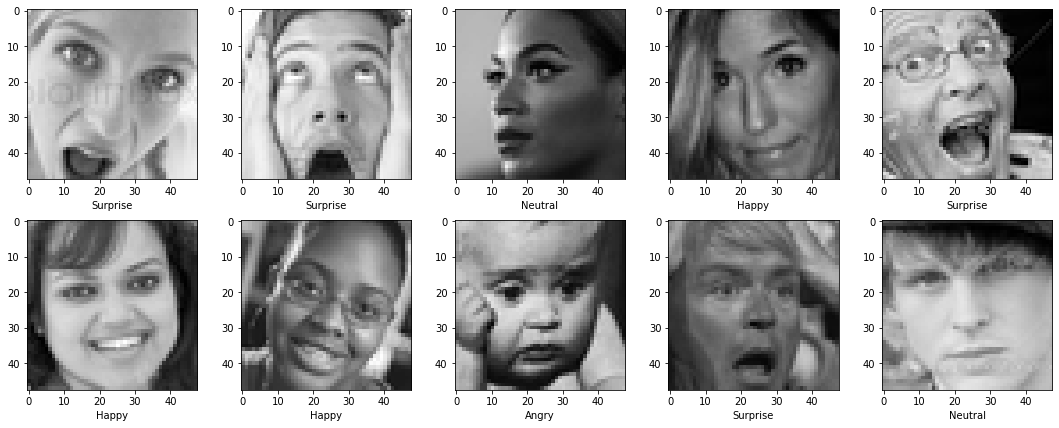

In [ ]:
plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xlabel(LABEL_MAPPING[ord_labels[i]])
    plt.imshow(images[i])
plt.tight_layout()
plt.show()

We can see that the images are a bit low in quality. They are only 48x48 pixels in size.  
We should be careful while resizing the images for our neural networks, since it may result in further degradation in quality.

# Model training and cross-validation framework

In [ ]:
PATIENCE = 15
MAX_EPOCHS = 100

In [ ]:
def get_batches(data, augment_args): # data pipeline
    X_train, y_train, X_test = data

    if augment_args:
        train_datagen = ImageDataGenerator(
            rescale=1./255, validation_split=0.2, **augment_args)
    else:
        train_datagen = ImageDataGenerator(
            rescale=1./255, validation_split=0.2)
    # unaffected by data augmentation
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_batches = train_datagen.flow(
        x=X_train, y=y_train, # default batch_size=32
        shuffle=False, # already shuffled in StratifiedKFold 
        seed=SEED,
        subset='training')
    val_batches = train_datagen.flow(
        x=X_train, y=y_train,
        shuffle=False,
        seed=SEED,
        subset='validation')
    test_batches = test_datagen.flow(
        x=X_test,
        batch_size=1,
        shuffle=False)
    return train_batches, val_batches, test_batches

In [ ]:
def build_model():
    INPUT_SHAPE = (48, 48, 3)
    model = tf.keras.models.Sequential([
        Conv2D(16, 3, activation='relu', input_shape=INPUT_SHAPE),
        Conv2D(16, 3, activation='relu'),
        MaxPool2D(),
        Conv2D(32, 3, activation='relu'),
        Conv2D(32, 3, activation='relu'),
        MaxPool2D(),
        Flatten(),
        Dropout(0.25),
        Dense(4, activation='softmax')
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(5e-4),
        metrics=['accuracy']
    )
    return model

In [ ]:
def fit_model(model, train_batches, val_batches, epochs):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        min_delta=2e-4,
        patience=PATIENCE,
        verbose=0,
        restore_best_weights=True
    )
    history = model.fit(
        x=train_batches,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=0,
        steps_per_epoch=len(train_batches),
        validation_data=val_batches,
        validation_steps=len(val_batches)
    )
    epochs_run = len(history.history['loss'])
    if epochs_run < MAX_EPOCHS:
        best_epoch = epochs_run - PATIENCE - 1
    else:
        best_epoch = MAX_EPOCHS - 1
    print(f'Stopped training after {epochs_run} epochs -> Best epoch: {best_epoch}')
    return model, history

In [ ]:
def plot_training_curve(history):
    epochs = len(history.history['loss'])
    if epochs < MAX_EPOCHS: # whether early stopping was triggered or not
        best_weights_at = epochs - PATIENCE - 1 # 0-indexed
    else:
        best_weights_at = MAX_EPOCHS - 1
    
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))
    ax[0].plot(range(epochs), train_loss, label='train_loss')
    ax[0].plot(range(epochs), val_loss, label='val_loss')
    ax[0].axvline(
        x=best_weights_at, color='red', linestyle='--', label='Best weights')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].minorticks_on()
    ax[0].legend()
    ax[1].plot(range(epochs), train_accuracy, label='train_accuracy')
    ax[1].plot(range(epochs), val_accuracy, label='val_accuracy')
    ax[1].axvline(
        x=best_weights_at, color='red', linestyle='--', label='Best weights')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].minorticks_on()
    ax[1].legend()
    plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, 
        normalize='true',
        values_format='.2f',
        display_labels=LABEL_MAPPING.values(), 
        cmap='Blues')
    cm.ax_.set_title(title, fontsize=15, ha='center')
    cm.figure_.set_figheight(5)
    cm.figure_.set_figwidth(6)
    plt.xticks(rotation=30)
    plt.show()

In [ ]:
def evaluate_on_test(model, test_batches, y_test):
    test_proba = model.predict(test_batches, verbose=0)
    test_preds = test_proba.argmax(axis=-1)
    y_true = np.argmax(y_test, axis=1)

    print('\nConfusion Matrix:')
    plot_confusion_matrix(y_true, test_preds, title='Out-of-fold predictions')

    print('\nOverall metrics:')
    print(f'\tAccuracy = {accuracy_score(y_true, test_preds):.4f}')
    print(f'\tTop-2 Accuracy = {top_k_accuracy_score(y_true, test_proba, k=2):.4f}')
    print(f'\tMacro F1-score = {f1_score(y_true, test_preds, average="macro"):.4f}')
    
    return test_preds

In [ ]:
def cv_predict(images, onehot_labels, augment_args=None, epochs=MAX_EPOCHS):
    oof = {} # Out-of-fold predictions for all samples
    ord_labels = np.argmax(onehot_labels, axis=1) # needed for stratifying

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    for fold, (train_idx, test_idx) in enumerate(cv.split(images, ord_labels)):
        print(f'\n---------- FOLD #{fold} ----------')
        X_train = images[train_idx]
        y_train = onehot_labels[train_idx]
        X_test = images[test_idx]
        y_test = onehot_labels[test_idx]
        
        train_batches, val_batches, test_batches = get_batches(
            (X_train, y_train, X_test), augment_args=augment_args)
        
        model, history = fit_model(
            build_model(), train_batches, val_batches, epochs)
        plot_training_curve(history)
        predictions = evaluate_on_test(model, test_batches, y_test)
        oof.update(dict(zip(test_idx, predictions)))
        _ = gc.collect()
    
    oof = pd.Series(oof).sort_index()
    return oof

# Model architecture

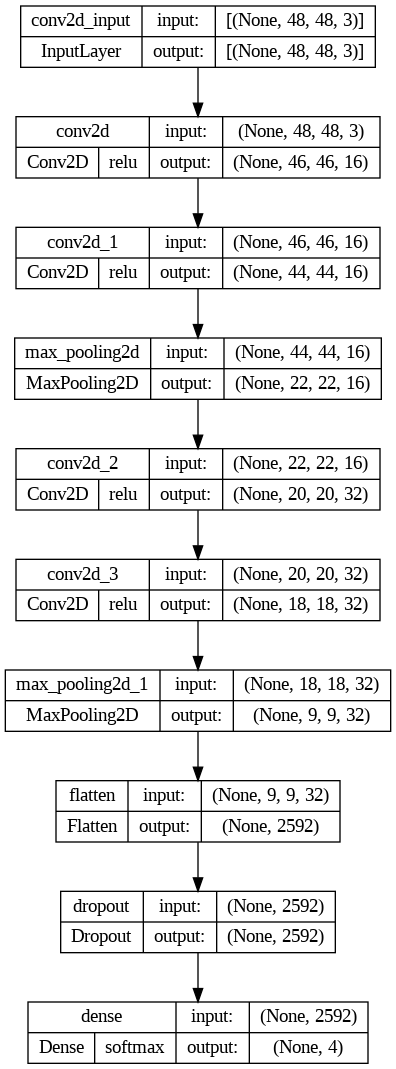

In [ ]:
plot_model(
    build_model(), 
    to_file='cnn_model_architecture.png', 
    show_shapes=True, 
    show_layer_activations=True
)

# Training with original images

### Cross-validation


---------- FOLD #0 ----------
Stopped training after 32 epochs -> Best epoch: 16


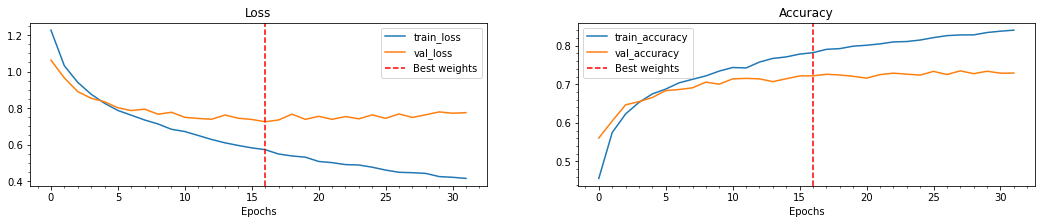


Confusion Matrix:


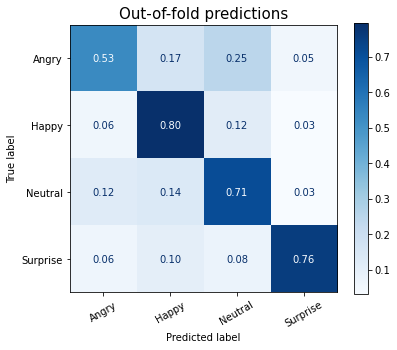


Overall metrics:
	Accuracy = 0.7160
	Top-2 Accuracy = 0.8940
	Macro F1-score = 0.7042

---------- FOLD #1 ----------
Stopped training after 34 epochs -> Best epoch: 18


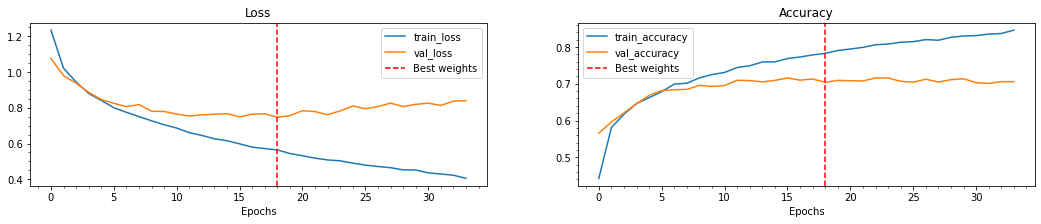


Confusion Matrix:


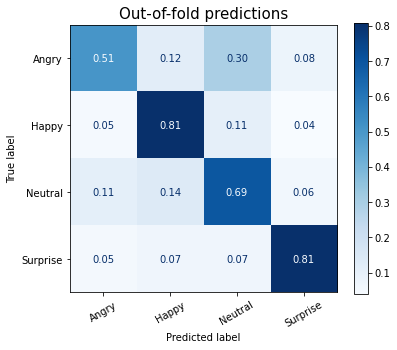


Overall metrics:
	Accuracy = 0.7206
	Top-2 Accuracy = 0.8947
	Macro F1-score = 0.7046

---------- FOLD #2 ----------
Stopped training after 31 epochs -> Best epoch: 15


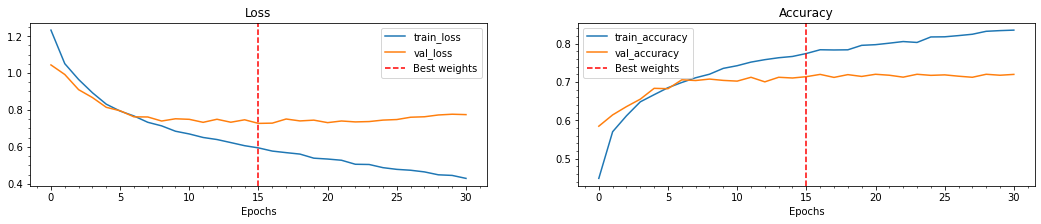


Confusion Matrix:


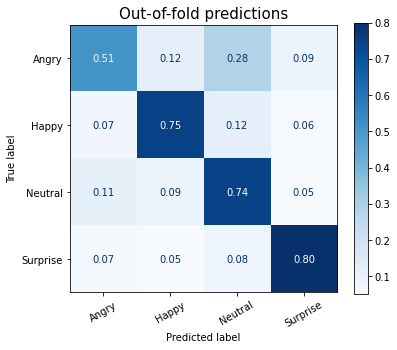


Overall metrics:
	Accuracy = 0.7115
	Top-2 Accuracy = 0.8807
	Macro F1-score = 0.6973

---------- FOLD #3 ----------
Stopped training after 30 epochs -> Best epoch: 14


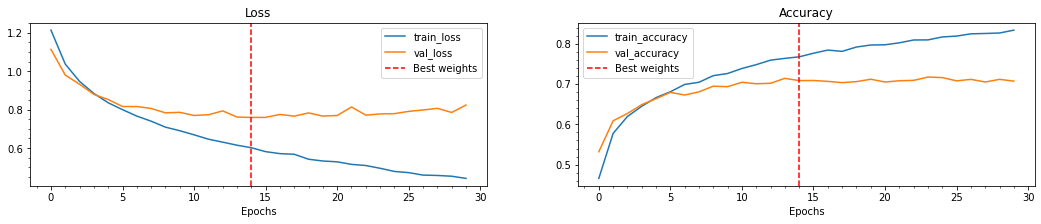


Confusion Matrix:


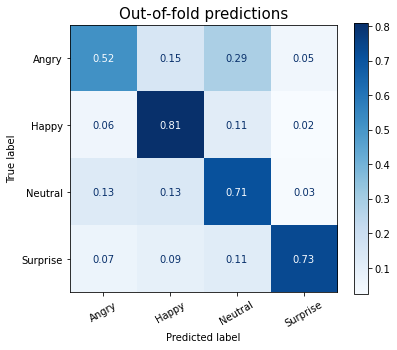


Overall metrics:
	Accuracy = 0.7130
	Top-2 Accuracy = 0.8932
	Macro F1-score = 0.6989

---------- FOLD #4 ----------
Stopped training after 36 epochs -> Best epoch: 20


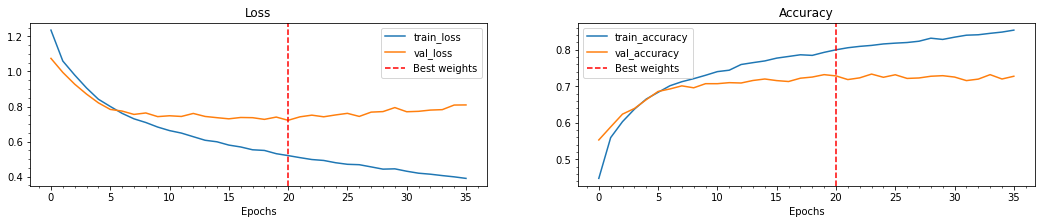


Confusion Matrix:


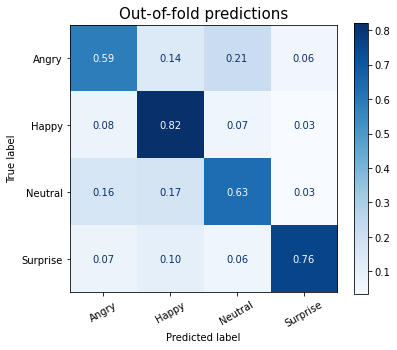


Overall metrics:
	Accuracy = 0.7163
	Top-2 Accuracy = 0.8905
	Macro F1-score = 0.7038
CPU times: user 10min 30s, sys: 40.2 s, total: 11min 10s
Wall time: 9min 17s


In [ ]:
%%time
oof_org = cv_predict(images, labels, augment_args=None)

### Overall performance

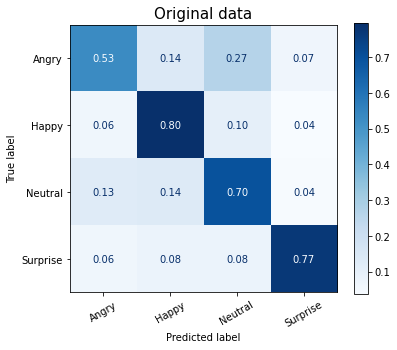

In [ ]:
plot_confusion_matrix(ord_labels, oof_org, title='Original data')

In [ ]:
print(f'Accuracy = {accuracy_score(ord_labels, oof_org):.4f}')

Accuracy = 0.7155


# Training with augmented images

### Cross-validation

In [ ]:
augment_args = {
    'rotation_range': 20, #degrees
    'shear_range': 0.05,
    'zoom_range': 0.2,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'horizontal_flip': True
}


---------- FOLD #0 ----------
Stopped training after 100 epochs -> Best epoch: 99


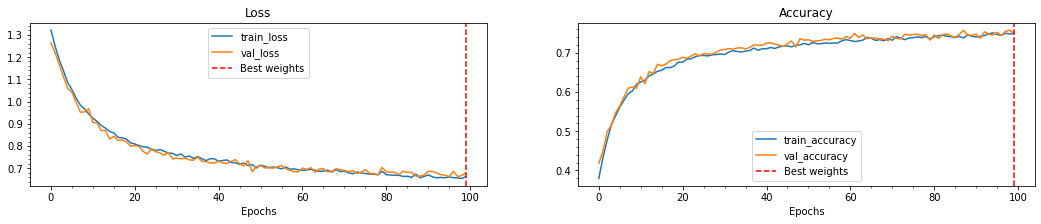


Confusion Matrix:


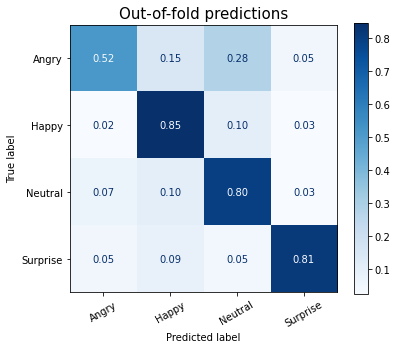


Overall metrics:
	Accuracy = 0.7649
	Top-2 Accuracy = 0.9226
	Macro F1-score = 0.7494

---------- FOLD #1 ----------
Stopped training after 100 epochs -> Best epoch: 99


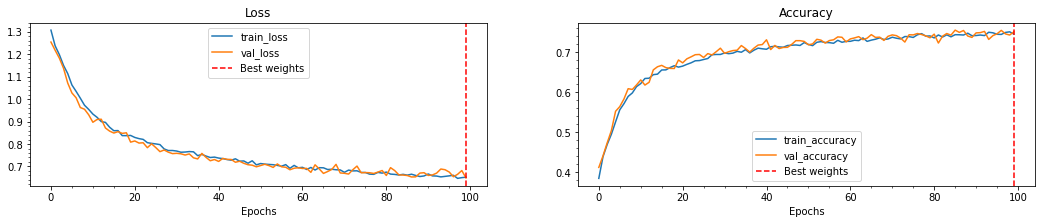


Confusion Matrix:


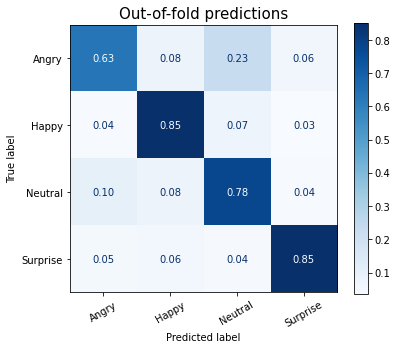


Overall metrics:
	Accuracy = 0.7887
	Top-2 Accuracy = 0.9298
	Macro F1-score = 0.7762

---------- FOLD #2 ----------
Stopped training after 100 epochs -> Best epoch: 99


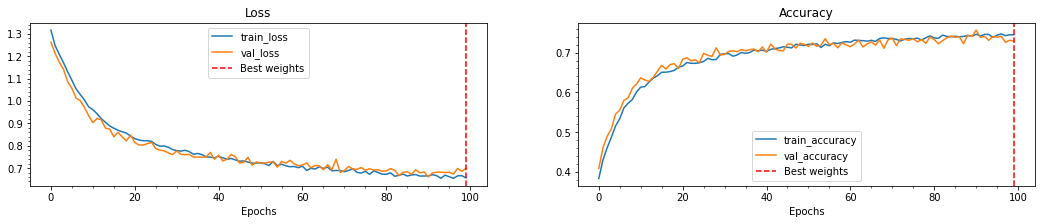


Confusion Matrix:


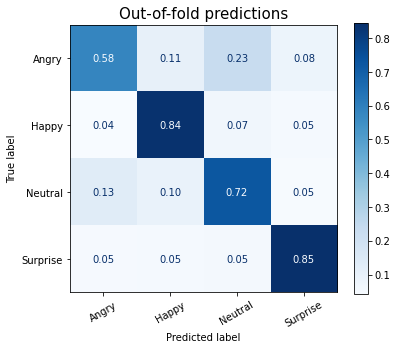


Overall metrics:
	Accuracy = 0.7609
	Top-2 Accuracy = 0.9206
	Macro F1-score = 0.7449

---------- FOLD #3 ----------
Stopped training after 100 epochs -> Best epoch: 99


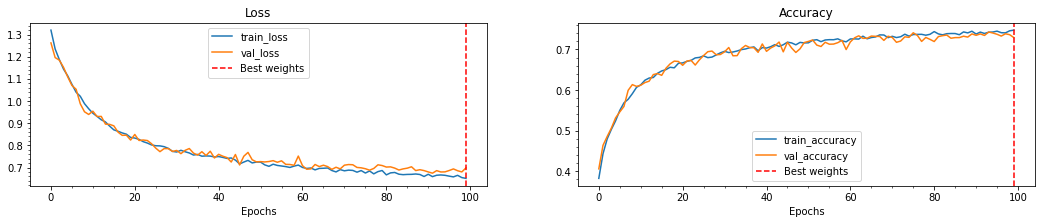


Confusion Matrix:


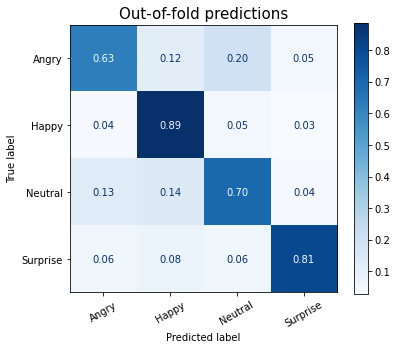


Overall metrics:
	Accuracy = 0.7734
	Top-2 Accuracy = 0.9288
	Macro F1-score = 0.7591

---------- FOLD #4 ----------
Stopped training after 95 epochs -> Best epoch: 79


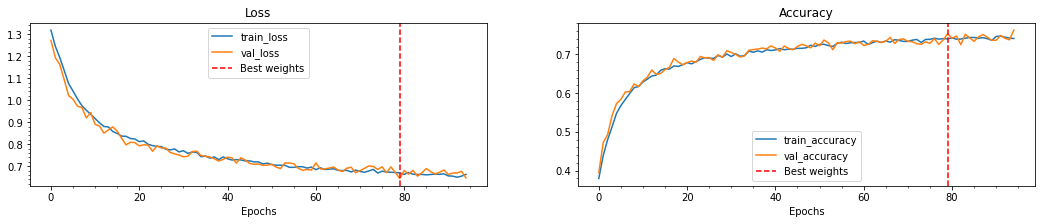


Confusion Matrix:


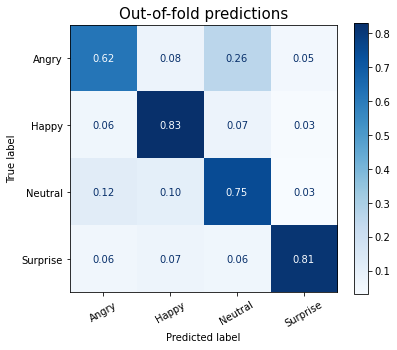


Overall metrics:
	Accuracy = 0.7642
	Top-2 Accuracy = 0.9273
	Macro F1-score = 0.7526
CPU times: user 2h 20min 5s, sys: 2min 44s, total: 2h 22min 49s
Wall time: 2h 11min 12s


In [ ]:
%%time
oof_aug = cv_predict(images, labels, augment_args=augment_args)

### Overall performance

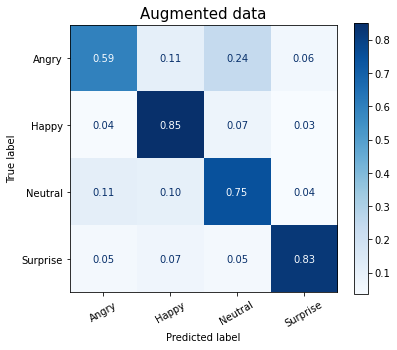

In [ ]:
plot_confusion_matrix(ord_labels, oof_aug, title='Augmented data')

In [ ]:
print(f'Accuracy = {accuracy_score(ord_labels, oof_aug):.4f}')

Accuracy = 0.7704


# Summary

* We trained a CNN model to classify images belonging to 4 categories of emotion - Angry, Happy, Neutral, Surprised.
* We set up a 5-fold cross-validation framework. 80% of the data is used for training + validation, while 20% is used as a holdout test set. In this way all images are present in a holdout set exactly once, which allows us to make predictions for all our images.
* The data is split in a stratified manner based on the class distribution. The class ratio is same in every test set and also reflects the ratio in the original data.
* The CNN model is trained in two configurations: 
    * on the original data only
    * on augmented data
* Performance (Accuracy):
    * Original data: Folds - 0.7115 to 0.7206, Overall - 0.7155
    * Augmented data: Folds - 0.7609 to 0.7887, Overall - 0.7704
* Performance vs Resources tradeoff: 
    * Looking at the training curves, we can see the training on augmented data gives a stable performance, as the validation loss and accuracy are almost perfectly mirroring the training loss and accuracy. Additionally, augmenting the data boosts accuracy by ≈0.6, which is a significant improvement.
    * However, looking at the training times we can see that artificially increasing the data size through augmentation also increases the training time required to complete. The difference is in several orders of magnitude i.e., 9-10 mins vs 2+ hours.

* Results analysis:
    * 'Happy' and 'Surprise' are exaggerated expressions i.e., having more pronounced effect on facial features, hence they are correctly classified more often (80-85%).
    * 'Neutral' is close behind, since it can be identified by a lack of effect on facial features (≈75%).
    * 'Anger' has a wider spectrum, sometimes very clear through a frown or scrunched eyebrows, sometimes very neutral in the form of pursed lips. Due to this, it is classified correctly less often (58-62%). As expected, the most common misclassification for 'Anger' is 'Neutral' (23-27%).